Hunter Bennett  
Glass Lab  
171211

Notebook for exploration of WGCNA R package using the liver strains data. Following the tutorial PDF for the WGCNA package found here:  

https://labs.genetics.ucla.edu/horvath/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/index.html

In [1]:
getwd()

[1] "/gpfs/data01/glasslab/home/h1bennet/liverStrains/results"

In [2]:
outdir <- '171208_WGCNA/'

In [3]:
library(WGCNA)

Loading required package: dynamicTreeCut
Loading required package: fastcluster

Attaching package: ‘fastcluster’

The following object is masked from ‘package:stats’:

    hclust

Warning message:
“replacing previous import ‘stats::sd’ by ‘BiocGenerics::sd’ when loading ‘S4Vectors’”Warning message:
“replacing previous import ‘stats::var’ by ‘BiocGenerics::var’ when loading ‘S4Vectors’”Warning message:
“multiple methods tables found for ‘var’”Warning message:
“multiple methods tables found for ‘sd’”Warning message:
“multiple methods tables found for ‘rowSums’”Warning message:
“multiple methods tables found for ‘colSums’”Warning message:
“multiple methods tables found for ‘rowMeans’”Warning message:
“multiple methods tables found for ‘colMeans’”Warning message:
“replacing previous import ‘BiocGenerics::rowSums’ by ‘S4Vectors::rowSums’ when loading ‘AnnotationDbi’”Warning message:
“replacing previous import ‘BiocGenerics::var’ by ‘S4Vectors::var’ when loading ‘AnnotationDbi’”Warning messa

*
*  Package WGCNA 1.51 loaded.
*
*    Important note: It appears that your system supports multi-threading,
*    but it is not enabled within WGCNA in R. 
*    To allow multi-threading within WGCNA with all available cores, use 
*
*          allowWGCNAThreads()
*
*    within R. Use disableWGCNAThreads() to disable threading if necessary.
*    Alternatively, set the following environment variable on your system:
*
*          ALLOW_WGCNA_THREADS=<number_of_processors>
*
*    for example 
*
*          ALLOW_WGCNA_THREADS=56
*
*    To set the environment variable in linux bash shell, type 
*
*           export ALLOW_WGCNA_THREADS=56
*
*     before running R. Other operating systems or shells will
*     have a similar command to achieve the same aim.
*





Attaching package: ‘WGCNA’

The following object is masked from ‘package:stats’:

    cor



In [4]:
options(stringsAsFactors = FALSE)
liverData = read.csv('/home/h1bennet/liverStrains/results/171208_RNA_Seq/kupffer_tpm_counts.txt',
                    sep='\t')

In [10]:
dim(liverData)

[1] 23205    17

In [11]:
datExpr0 = as.data.frame(t(liverData));
datExpr0 = datExpr0[-1,]
names(datExpr0) <- liverData[,1]

In [12]:
#convert to numeric
datExpr0 <- sapply(datExpr0, as.numeric)

In [16]:
rownames(datExpr0) <- names(liverData[,-1])

In [20]:
dim(datExpr0)

[1]    16 23205

In [19]:
# check samples to see if we have too many missing values
gsg = goodSamplesGenes(datExpr0, verbose = 3);
gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 4546 genes from the calculation due to too many missing samples or zero variance.
  ..step 2


[1] FALSE

In [21]:
# remove samples or genes with too much missing data
if (!gsg$allOK)
{
# Optionally, print the gene and sample names that were removed:
if (sum(!gsg$goodGenes)>0)
printFlush(paste("Removing genes:", paste(names(datExpr0)[!gsg$goodGenes], collapse = ", ")));
if (sum(!gsg$goodSamples)>0)
printFlush(paste("Removing samples:", paste(rownames(datExpr0)[!gsg$goodSamples], collapse = ", ")));
# Remove the offending genes and samples from the data:
datExpr0 = datExpr0[gsg$goodSamples, gsg$goodGenes]
}

Removing genes: 


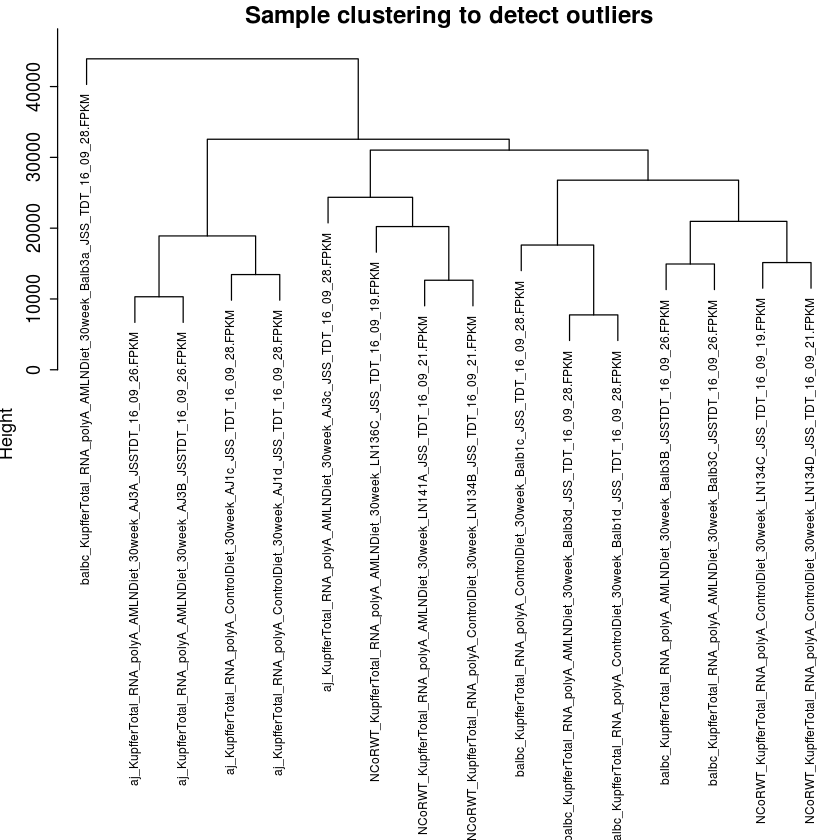

In [24]:
# cluster samples to see if we have outliers
sampleTree = hclust(dist(datExpr0), method = "average");
# Plot the sample tree: Open a graphic output window of size 12 by 9 inches
# The user should change the dimensions if the window is too large or too small.|
#pdf(file = "Plots/sampleClustering.pdf", width = 12, height = 9);
par(cex = 0.6);
par(mar = c(0,4,2,0))
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="", cex.lab = 1.5,
    cex.axis = 1.5, cex.main = 2)

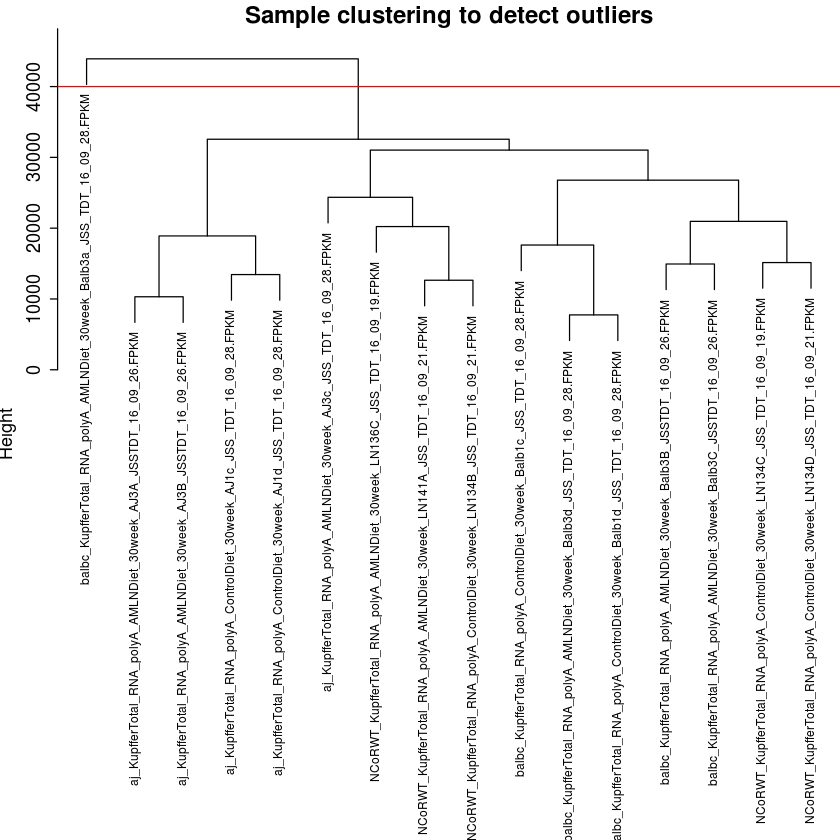

In [28]:
# yet again it looks like 3A is an outlier, we will exclude it by cutting the tree at 40000
par(cex = 0.6);
par(mar = c(0,4,2,0))
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="", cex.lab = 1.5,
    cex.axis = 1.5, cex.main = 2)
abline(h = 40000, col = "red");

In [29]:
# Determine cluster under the line
clust = cutreeStatic(sampleTree, cutHeight = 40000, minSize = 10)
table(clust)
# clust 1 contains the samples we want to keep.
keepSamples = (clust==1)
datExpr = datExpr0[keepSamples, ]
nGenes = ncol(datExpr)
nSamples = nrow(datExpr)

clust
 0  1 
 1 15 

In [36]:
# now we load in the "clinical trait data"
traitData = read.csv('/home/h1bennet/liverStrains/results/171208_RNA_Seq/amln_samples.txt',
                    sep='\t')
dim(traitData)
names(traitData)

[1] 34 11

[1] "X"            "subject"      "sample_type"  "path"         "batch"       
 [6] "strain"       "diet"         "group"        "group_tissue" "exclusion"   
[11] "color"

In [43]:
# remove unneeded traits
allTraits = traitData[, -c(1, 4, 10)];
kup = (traitData$sample_type=='kupffer')
allTraits = allTraits[kup,]
# remove 3A
allTraits = allTraits[-6,]

In [53]:
# make data frame matching expression set that holds clinical traits
kupSamples = gsub('\\.FPKM', '', rownames(datExpr));
traitRows = match(kupSamples, allTraits$subject);
datTraits = allTraits[traitRows, -1];
rownames(datTraits) = allTraits[traitRows, 1];

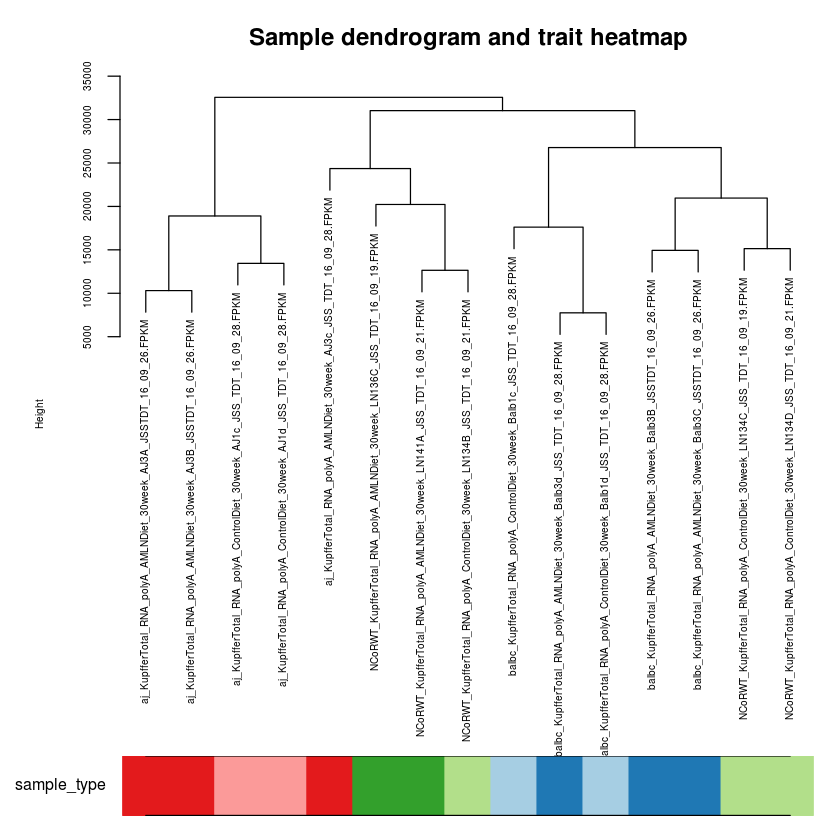

In [67]:
# Re-cluster samples
sampleTree2 = hclust(dist(datExpr), method = "average")
# Convert traits to a color representation: white means low, red means high, grey means missing entry
traitColors = datTraits$color;
# Plot the sample dendrogram and the colors underneath.
plotDendroAndColors(sampleTree2, traitColors,
                    groupLabels = names(datTraits),
                    main = "Sample dendrogram and trait heatmap",
                    xlab="", cex.lab = 0.5,
                    cex.axis = 0.5, cex.dendroLabels=0.5,
                    autoColorHeight = FALSE, colorHeight = 0.1)

In [76]:
save(datExpr, datTraits, file = paste0(outdir,"amlnKupffer-01-dataInput.RData"))

In [5]:
# if starting here..
lnames = load(file = paste0(outdir,"amlnKupffer-01-dataInput.RData"));

In [7]:
# Do initial WGCNA analysis
# enable multithreads
enableWGCNAThreads(nThreads=16)

Allowing parallel execution with up to 16 working processes.


pickSoftThreshold: will use block size 2397.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 2397 of 18659
   ..working on genes 2398 through 4794 of 18659
   ..working on genes 4795 through 7191 of 18659
   ..working on genes 7192 through 9588 of 18659
   ..working on genes 9589 through 11985 of 18659
   ..working on genes 11986 through 14382 of 18659
   ..working on genes 14383 through 16779 of 18659
   ..working on genes 16780 through 18659 of 18659


Warning message in as.vector(log10(dk)):
“NaNs produced”Warning message in as.vector(log10(dk)):
“NaNs produced”

   Power SFT.R.sq   slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.7890 12.1000          0.824  5530.0    5490.0   7880
2      2   0.0245  0.1710          0.716  2510.0    2350.0   4850
3      3   0.0104 -0.0923          0.705  1410.0    1210.0   3530
4      4   0.6800 -0.7920          0.827   897.0     706.0   2790
5      5   0.8690 -1.0400          0.893   620.0     442.0   2320
6      6   0.9230 -1.1500          0.920   454.0     292.0   1980
7      7   0.9490 -1.2200          0.940   347.0     210.0   1730
8      8   0.9640 -1.2600          0.955   274.0     151.0   1530
9      9   0.9690 -1.2900          0.961   222.0     114.0   1380
10    10   0.9740 -1.3100          0.966   183.0      87.6   1250
11    12   0.9770 -1.3300          0.971   131.0      55.8   1050
12    14   0.9730 -1.3500          0.966    98.5      35.9    905
13    16   0.9710 -1.3500          0.965    76.8      23.9    791
14    18   0.9700 -1.3600          0.967    61.5      16.4    699
15    20  

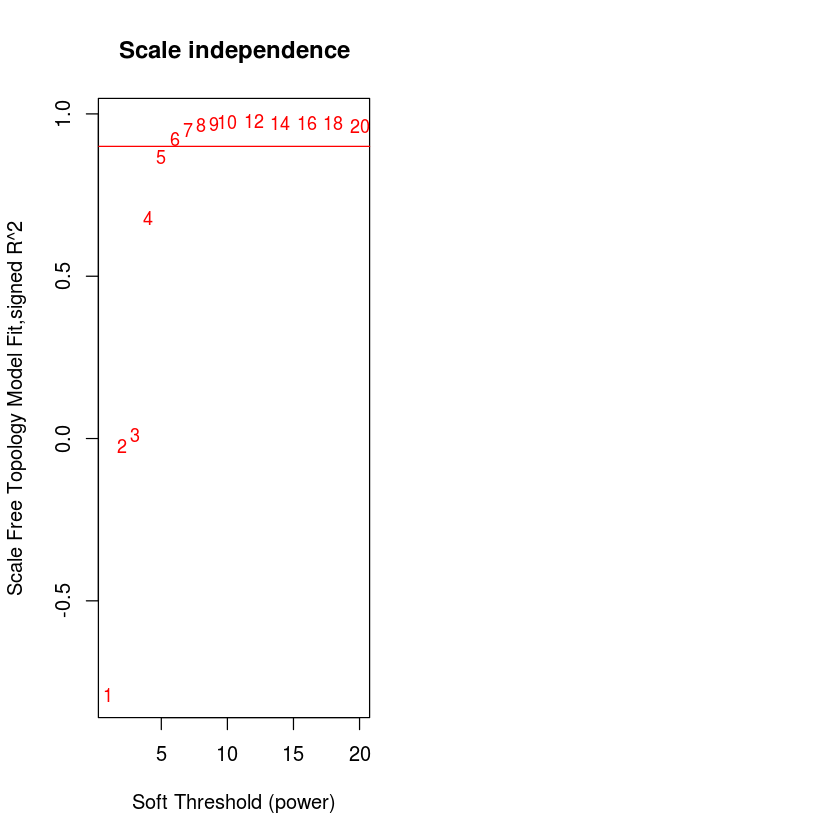

In [8]:
# Choose a set of soft-thresholding powers
powers = c(c(1:10), seq(from = 12, to=20, by=2))
# Call the network topology analysis function
sft = pickSoftThreshold(datExpr, powerVector = powers, verbose = 5)
# Plot the results:
par(mfrow = c(1,2));
cex1 = 0.9;
# Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
main = paste("Scale independence"));
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
labels=powers,cex=cex1,col="red");
# this line corresponds to using an R^2 cut-off of h
abline(h=0.90,col="red")

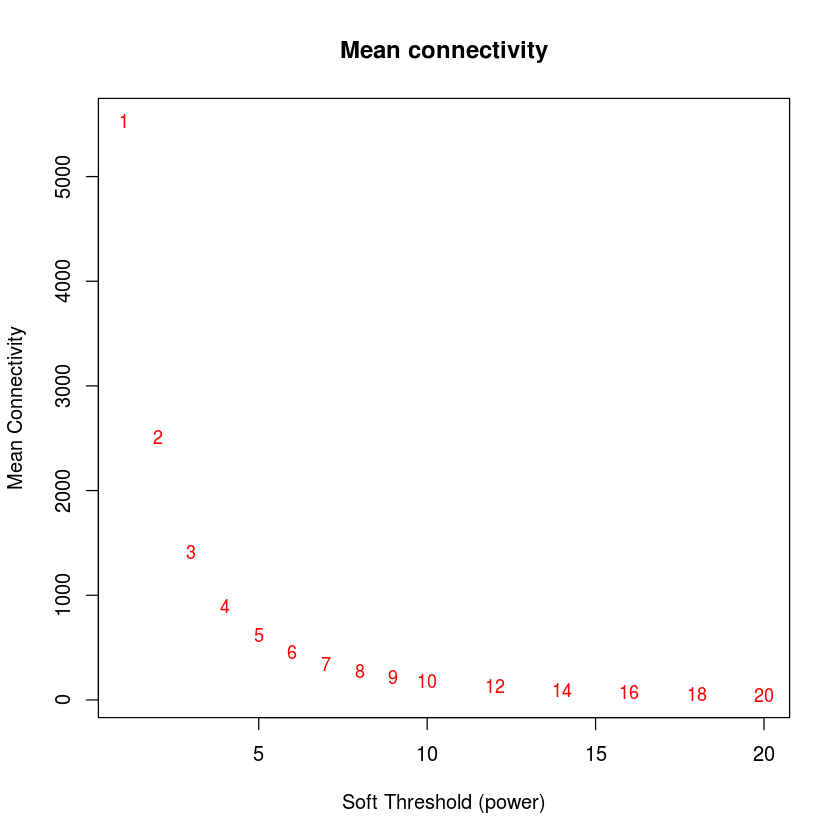

In [9]:
# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],
xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")

In [10]:
# currently we are just running this 'out of the box' settings except for a higher max block
# can use more blocks because we have a cluster with sig more RAM
net = blockwiseModules(datExpr, power = 8,
                       TOMType = "unsigned", minModuleSize = 30,
                       reassignThreshold = 0, mergeCutHeight = 0.25,
                       numericLabels = TRUE, pamRespectsDendro = FALSE,
                       saveTOMs = TRUE,
                       saveTOMFileBase = paste0(outdir, "kupfferTOM"),
                       verbose = 3,
                       maxBlockSize=20000)

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
  ..Excluding 76 genes from the calculation due to too many missing samples or zero variance.
    ..step 2
 ..Working on block 1 .
    TOM calculation: adjacency..
adjacency: replaceMissing: 0
    ..will use 16 parallel threads.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file 171208_WGCNA/kupfferTOM-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking modules for statistical meaningfulness..
     ..removing 1 genes from module 5 because their KME is too low.
     ..removing 1 genes from module 10 because their KME is too low.
     ..removing 1 genes from module 16 because their KME is too low.
     ..removing 1 genes from module 31 because their KME is too low.
     ..removing 1 genes

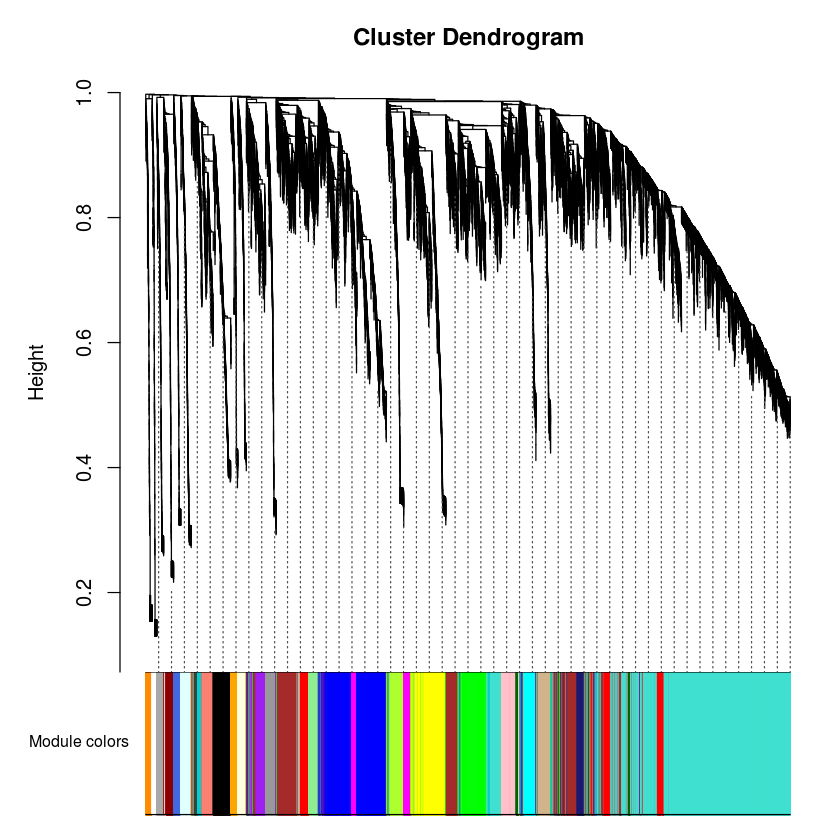

In [11]:
# Convert labels to colors for plotting
mergedColors = labels2colors(net$colors)
# Plot the dendrogram and the module colors underneath
plotDendroAndColors(net$dendrograms[[1]], mergedColors[net$blockGenes[[1]]],
        "Module colors",
        dendroLabels = FALSE, hang = 0.03,
        addGuide = TRUE, guideHang = 0.05)

In [12]:
moduleLabels = net$colors
moduleColors = labels2colors(net$colors)
MEs = net$MEs;
geneTree = net$dendrograms[[1]];
save(MEs, moduleLabels, moduleColors, geneTree,
     file = paste0(outdir, "kupfferTOM-02-networkConstruction-auto.RData"))

### Now that we have modules we can see if any of them are specifically enriched in certain individuals of interest. In particular we want to see if any are enriched in the specific strains on the AMLN diet versus all the other conditions 
____
Therefore we should go through correlating the vectors with 1's for the strain-diet combo of interest and 0's for the rest with the gene modules and look for the ones that are most significant

In [64]:
# Define numbers of genes and samples
nGenes = ncol(datExpr);
nSamples = nrow(datExpr);

In [103]:
# create function for converting categorical variables to numeric
numerize <- function(x) {
    x <- as.numeric(factor(x))
    x <- x -1
    x
}

In [112]:
# fix the datTraits variable
datTraits$aj = as.numeric(datTraits$strain == 'aj')
datTraits$balb = as.numeric(datTraits$strain == 'balbc')
datTraits$ncorwt = as.numeric(datTraits$strain == 'ncorwt')
datTraits$aj_amln = as.numeric(datTraits$group == 'aj-amln')
datTraits$balb_amln = as.numeric(datTraits$group == 'balbc-amln')
datTraits$ncorwt_amln = as.numeric(datTraits$group == 'ncorwt-amln')
datTraitsn <- data.frame(lapply(datTraits[, c(8:13)], numerize))
rownames(datTraitsn) <- rownames(datTraits)

In [113]:
# Recalculate MEs with color labels
MEs0 = moduleEigengenes(datExpr, moduleColors)$eigengenes
MEs = orderMEs(MEs0)
moduleTraitCor = cor(MEs, datTraitsn, use = "p");
moduleTraitPvalue = corPvalueStudent(moduleTraitCor, nSamples);

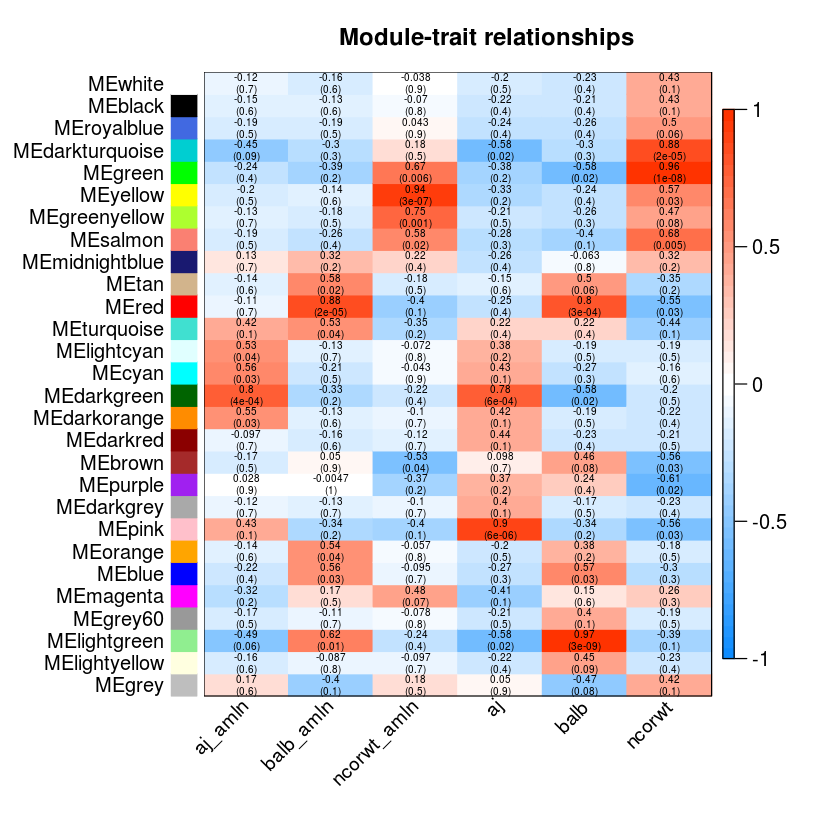

In [114]:
# Will display correlations and their p-values
textMatrix = paste(signif(moduleTraitCor, 2), "\n(",
    signif(moduleTraitPvalue, 1), ")", sep = "");
dim(textMatrix) = dim(moduleTraitCor)
par(mar = c(6, 8.5, 3, 3));

labeledHeatmap(Matrix = moduleTraitCor,
    xLabels = names(datTraitsn),
    yLabels = names(MEs),
    ySymbols = names(MEs),
    colorLabels = FALSE,
    colors = blueWhiteRed(50),
    textMatrix = textMatrix,
    setStdMargins = FALSE,
    cex.text = 0.5,
    zlim = c(-1,1),
    main = paste("Module-trait relationships"))

In [81]:
# Define variable weight containing the weight column of datTrait
strain = as.data.frame(datTraitsn$strain);
names(strain) = "strain"

# names (colors) of the modules
modNames = substring(names(MEs), 3)

geneModuleMembership = as.data.frame(cor(datExpr, MEs, use = "p"));
MMPvalue = as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples));

names(geneModuleMembership) = paste("MM", modNames, sep="");
names(MMPvalue) = paste("p.MM", modNames, sep="");

geneTraitSignificance = as.data.frame(cor(datExpr, strain, use = "p"));
GSPvalue = as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance), nSamples));

names(geneTraitSignificance) = paste("GS.", names(strain), sep="");
names(GSPvalue) = paste("p.GS.", names(strain), sep="");

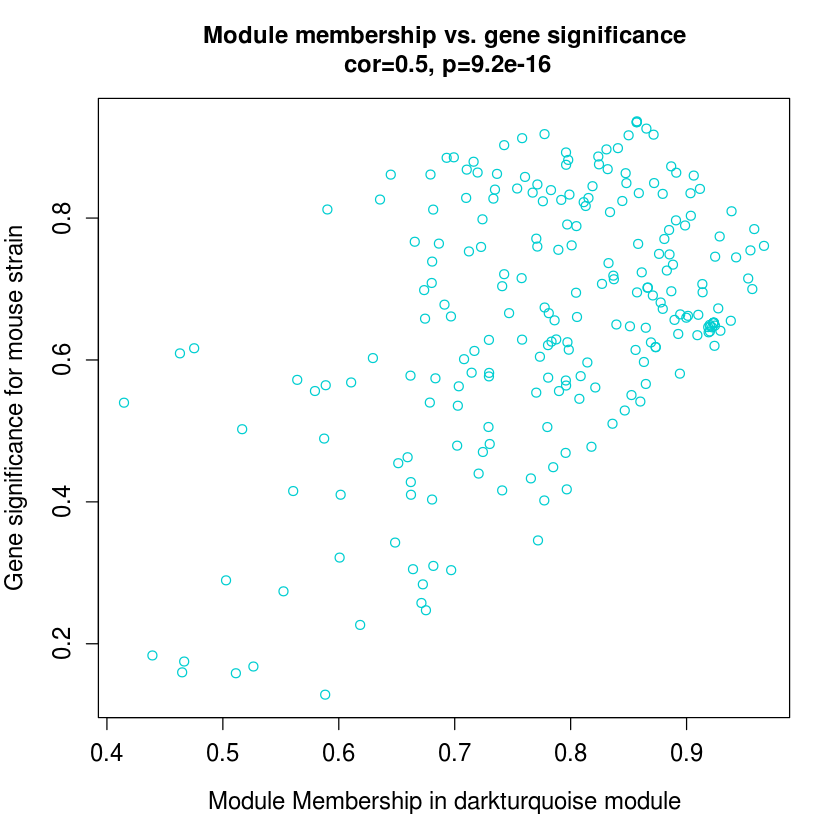

In [88]:
module = "darkturquoise"
column = match(module, modNames);
moduleGenes = moduleColors==module;
par(mfrow = c(1,1));
verboseScatterplot(abs(geneModuleMembership[moduleGenes, column]),
    abs(geneTraitSignificance[moduleGenes, 1]),
    xlab = paste("Module Membership in", module, "module"),
    ylab = "Gene significance for mouse strain",
    main = paste("Module membership vs. gene significance\n"),
    cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = module)